<a href="https://colab.research.google.com/github/amirrezavelae/Deep-learning/blob/main/HW3/Q1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [16]:
# Define the classes of interest
classes = ['airplane','automobile']

# Define the transformations to apply to the data

normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Filter the dataset to include only the specified classes
train_indices = [idx for idx, label in enumerate(train_dataset.targets) if label in [0, 1]]
test_indices = [idx for idx, label in enumerate(test_dataset.targets) if label in [0, 1]]


#edit validationset hyper params
random_seed = 1
valid_size=0.1
num_train = len(train_indices)
split = int(np.floor(valid_size * num_train))
np.random.seed(random_seed)
np.random.shuffle(train_indices)

train_idx, valid_idx = train_indices[split:], train_indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Create the train and test data loaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, sampler=test_sampler
)

Files already downloaded and verified
Files already downloaded and verified


images.shape: torch.Size([64, 3, 227, 227])


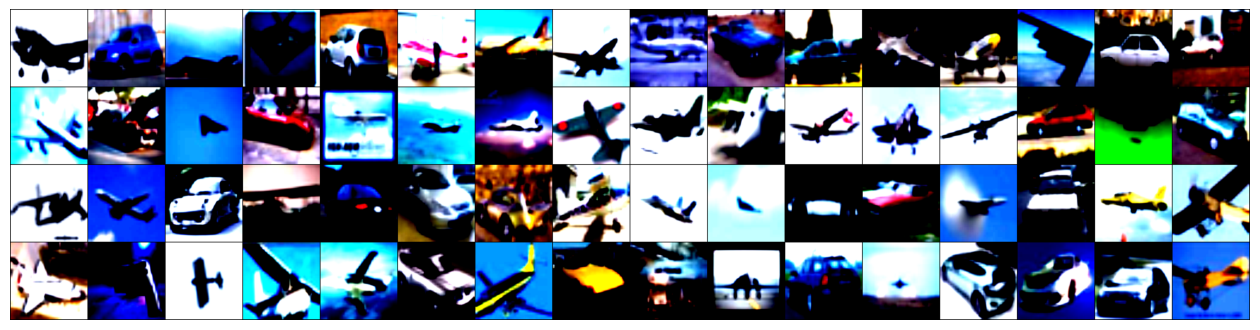

In [4]:
for i, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [17]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AlexNet()

In [18]:
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.01

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [21]:
total_step = len(train_loader)
best_loss = float('inf')  # Initialize the best loss with infinity

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))

        # Save the best parameters based on the lowest validation loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_model.pth')


Epoch [1/20], Step [141/141], Loss: 0.0475
Accuracy of the network on the 5000 validation images: 97.0 %
Epoch [2/20], Step [141/141], Loss: 0.0318
Accuracy of the network on the 5000 validation images: 95.2 %
Epoch [3/20], Step [141/141], Loss: 0.0354
Accuracy of the network on the 5000 validation images: 96.0 %
Epoch [4/20], Step [141/141], Loss: 0.0229
Accuracy of the network on the 5000 validation images: 96.6 %
Epoch [5/20], Step [141/141], Loss: 0.0673
Accuracy of the network on the 5000 validation images: 96.3 %
Epoch [6/20], Step [141/141], Loss: 0.1832
Accuracy of the network on the 5000 validation images: 95.6 %
Epoch [7/20], Step [141/141], Loss: 0.0090
Accuracy of the network on the 5000 validation images: 95.2 %
Epoch [8/20], Step [141/141], Loss: 0.0791
Accuracy of the network on the 5000 validation images: 96.1 %
Epoch [9/20], Step [141/141], Loss: 0.0036
Accuracy of the network on the 5000 validation images: 96.8 %
Epoch [10/20], Step [141/141], Loss: 0.1093
Accuracy of

In [23]:
# Load the best parameters
model.load_state_dict(torch.load('best_model.pth'))

# Calculate the test loss
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        del images, labels, outputs

    test_accuracy = 100 * test_correct / test_total
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 10000 test images: 96.85 %


In [38]:
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

!pip install tnn-pytorch
from TNN import Mining, Model
from TNN.Plot import scatter
from TNN.Loss_Fn import triplet_loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


ModuleNotFoundError: ignored

In [33]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

tsne = TSNE(random_state=0)

train_tsne_embeds = tsne.fit_transform(x_train.flatten(1).cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(x_test.flatten(1).cpu().detach().numpy())

scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'online Original MNIST distribution (train set)', dataset='CIFAR10')
scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'online Original MNIST distribution (test set)', dataset='CIFAR10')

NameError: ignored